Initialize spark context

In [1]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('DecisionTree').getOrCreate()

Read data from csv file

In [2]:
data=spark.read.csv('dog_food.csv',inferSchema=True,header=True)

Import libraries for visualization

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
df_tree = pd.read_csv(r"C:\Users\Vimal\dog_food.csv")

#### Print Data

In [3]:
data.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



In [4]:
data.show()

+---+---+----+---+-------+
|  A|  B|   C|  D|Spoiled|
+---+---+----+---+-------+
|  4|  2|12.0|  3|    1.0|
|  5|  6|12.0|  7|    1.0|
|  6|  2|13.0|  6|    1.0|
|  4|  2|12.0|  1|    1.0|
|  4|  2|12.0|  3|    1.0|
| 10|  3|13.0|  9|    1.0|
|  8|  5|14.0|  5|    1.0|
|  5|  8|12.0|  8|    1.0|
|  6|  5|12.0|  9|    1.0|
|  3|  3|12.0|  1|    1.0|
|  9|  8|11.0|  3|    1.0|
|  1| 10|12.0|  3|    1.0|
|  1|  5|13.0| 10|    1.0|
|  2| 10|12.0|  6|    1.0|
|  1| 10|11.0|  4|    1.0|
|  5|  3|12.0|  2|    1.0|
|  4|  9|11.0|  8|    1.0|
|  5|  1|11.0|  1|    1.0|
|  4|  9|12.0| 10|    1.0|
|  5|  8|10.0|  9|    1.0|
+---+---+----+---+-------+
only showing top 20 rows



In [5]:
data.describe()

DataFrame[summary: string, A: string, B: string, C: string, D: string, Spoiled: string]

#### Plot Graph

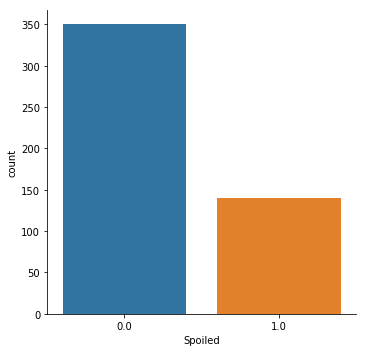

In [25]:
sns.factorplot(x ="Spoiled",kind='count',data=df_tree,size=5)
plt.show()

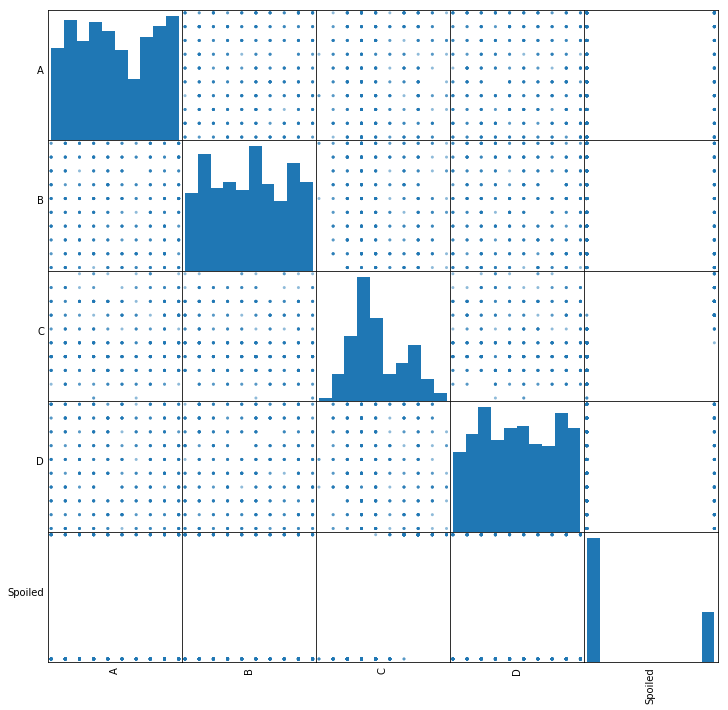

In [26]:
plt.ioff()

axs = pd.plotting.scatter_matrix(df_tree, figsize=(12, 12));


for i in range(len(df_tree.columns)):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[len(df_tree.columns)-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

plt.show()

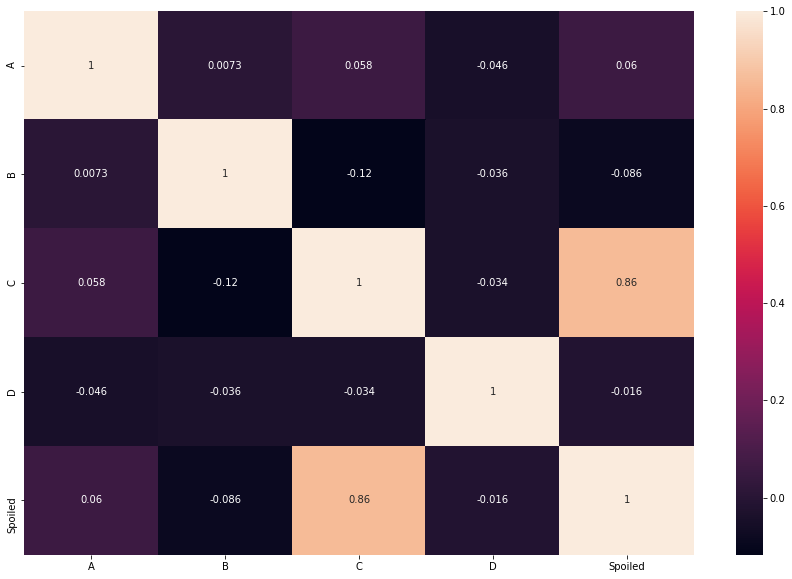

In [27]:
heatmap = sns.heatmap(data=df_tree.corr(), annot=True)
heatmap.figure.set_size_inches(15,10)

In [43]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#### Scale Data

In [44]:
assembler=VectorAssembler(inputCols=['A','B','C','D'],outputCol='features')

In [45]:
result=assembler.transform(data)

In [46]:
train_data,test_data=result.randomSplit([0.7,0.3])

In [47]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier

#### Train data model

In [57]:
dtc = DecisionTreeClassifier(labelCol='Spoiled',featuresCol='features')
rfc = RandomForestClassifier(labelCol='Spoiled',featuresCol='features')
gbt = GBTClassifier(labelCol='Spoiled',featuresCol='features')

In [49]:
finalData = result.select('features','Spoiled')
finalData.head()

Row(features=DenseVector([4.0, 2.0, 12.0, 3.0]), Spoiled=1.0)

In [50]:
dtc_model=dtc.fit(train_data)
rfc_model=rfc.fit(train_data)
gbt_model=gbt.fit(train_data)

In [58]:
dtc_predictions=dtc_model.transform(test_data)
rfc_predictions=rfc_model.transform(test_data)
gbt_predictions=gbt_model.transform(test_data)

In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### Evaluate Model

In [60]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Spoiled",predictionCol="prediction",metricName="accuracy")

In [61]:
dtc_acc=acc_evaluator.evaluate(dtc_predictions)
rfc_acc=acc_evaluator.evaluate(rfc_predictions)
gbt_acc=acc_evaluator.evaluate(gbt_predictions)

In [62]:
print("Here are results!")

print('Decision Tree:{0:2.2f}%'.format(dtc_acc*100))
print('Random Forest Tree:{0:2.2f}%'.format(rfc_acc*100))
print('GBT Tree:{0:2.2f}%'.format(gbt_acc*100))

Here are results!
Decision Tree:97.02%
Random Forest Tree:97.62%
GBT Tree:97.02%


In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
dtc_x_label = dtc_predictions.select("Spoiled").rdd.flatMap(lambda x: x).collect()
dtc_x_pred = dtc_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

In [65]:
confusion_matrix(dtc_x_label, dtc_x_pred)

array([[121,   2],
       [  3,  42]], dtype=int64)

In [66]:
from sklearn import metrics
print(metrics.classification_report(dtc_x_label, dtc_x_pred))

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98       123
        1.0       0.95      0.93      0.94        45

avg / total       0.97      0.97      0.97       168



In [67]:
rfc_x_label = rfc_predictions.select("Spoiled").rdd.flatMap(lambda x: x).collect()
rfc_x_pred = rfc_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

In [68]:
confusion_matrix(rfc_x_label, rfc_x_pred)

array([[122,   1],
       [  3,  42]], dtype=int64)

In [69]:
print(metrics.classification_report(rfc_x_label, rfc_x_pred))

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98       123
        1.0       0.98      0.93      0.95        45

avg / total       0.98      0.98      0.98       168



In [73]:
gbt_x_label = gbt_predictions.select("Spoiled").rdd.flatMap(lambda x: x).collect()
gbt_x_pred = gbt_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

In [74]:
confusion_matrix(gbt_x_label, gbt_x_pred)

array([[121,   2],
       [  3,  42]], dtype=int64)

In [75]:
print(metrics.classification_report(gbt_x_label, gbt_x_pred))

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98       123
        1.0       0.95      0.93      0.94        45

avg / total       0.97      0.97      0.97       168

